# Testing the Integrated Simulation Platform
This notebook contains codes to test the various functionalities of the integrated simulation platform. You can call any of the modules from the package here. 

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

C:\Users\sbalakrishna\AppData\Local\Temp\3\ipykernel_6604\1890965923.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Import required packages

In [2]:
from pathlib import Path
from infrarisk.src.network_recovery import *
import infrarisk.src.simulation as simulation
from infrarisk.src.physical.integrated_network import *
import infrarisk.src.recovery_strategies as strategies
import infrarisk.src.socioeconomic.se_analysis as se_analysis
from infrarisk.src.physical.interdependencies import *

import infrarisk.src.plots as model_plots
#hide warnings
import warnings
warnings.filterwarnings('ignore')

c:\Users\sbalakrishna\.conda\envs\infrarisk\lib\site-packages\geopandas\_compat.py:106: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Create an IntegratedNetwork object

In [3]:
shelby_network = IntegratedNetwork(name = "Shelby")

### Load the three infrastructure models: Water, Power and Transportation

Three different models are used:
- Water distribution network using **wntr** package
- Power systems using **pandapower** package
- Transportation network using static traffic assignment package developed by Dr. Stephen Boyles (University of Texas at Austin)

In [33]:
MAIN_DIR = Path('../..')
SIM_STEP = 60

network_dir= 'infrarisk/data/networks/shelby'
water_folder = MAIN_DIR/f'{network_dir}/water'
power_folder = MAIN_DIR/f'{network_dir}/power'
transp_folder = MAIN_DIR/f'{network_dir}/transportation/reduced'

# load all infrastructure networks
shelby_network.load_networks(water_folder=water_folder, 
                             power_folder=power_folder, 
                             transp_folder=transp_folder,
                             sim_step=SIM_STEP)

Water network successfully loaded from ..\..\infrarisk\data\networks\shelby\water/water.inp. The analysis type is set to PDA.
initial simulation duration: 60s; hydraulic time step: 60s; pattern time step: 3600s

Loading water service area details...
Power system successfully loaded from ..\..\infrarisk\data\networks\shelby\power\power.json. Single phase power flow simulation will be used.

Loading power service area details...
Transportation network successfully loaded from ..\..\infrarisk\data\networks\shelby\transportation\reduced. Static traffic assignment method will be used to calculate travel times.


### Create a Networkx graph of the integrated infrastructure network.

In [34]:
shelby_network.generate_integrated_graph(basemap = True)

Successfully added power network to the integrated graph...
Successfully added water network to the integrated graph...
Successfully added transportation network to the integrated graph...
Integrated graph successffully created.
Generating betweenness centrality...


Loading BokehJS ...

### Build interdependencies

Three types of dependencies:
- Power - Water dependencies (eg.: water pump on electric motor, generator on reservoir)
- Power - Transportation dependencies (eg.: road access to power system components for M&R)
- Water - Transportation dependencies (eg.: road access to water network components for M&R)

The dependencies are referenced using two tables in the model.
- **wp_table** for water - power dependencies
- **access_table** for transportation dependencies

In [35]:
dependency_file = MAIN_DIR/f"{network_dir}/dependencies.csv"
shelby_network.generate_dependency_table(dependency_file = dependency_file)
shelby_network.dependency_table.wp_table.head()

,water_id,power_id,water_type,power_type
0,W_WP81,P_MP81,Pump,Motor
1,W_WP82,P_MP82,Pump,Motor
2,W_WP83,P_MP83,Pump,Motor
3,W_WP84,P_MP84,Pump,Motor
4,W_WP85,P_MP85,Pump,Motor


In [36]:
shelby_network.dependency_table.access_table.head()

,origin_id,transp_id,origin_cat,origin_type,access_dist
0,P_B40L0,T_J153,power,Bus connected to load,2202.69
1,P_B57L0,T_J153,power,Bus connected to load,3411.97
2,P_B2L0,T_J58,power,Bus connected to load,1262.27
3,P_B12L0,T_J183,power,Bus connected to load,1195.67
4,P_B49L0,T_J54,power,Bus connected to load,698.73


# Socioeconomic data for Shelby County

In [37]:
year, tract, county, state = 2017, '*', 157, 47
county = 157
se_dir = MAIN_DIR/f"{network_dir}/gis/se_data"
if not os.path.exists(se_dir):
    os.makedirs(se_dir)

ShelbySE = se_analysis.SocioEconomicTable(name = 'Shelby', year = year, 
                                               tract = tract, state = state, 
                                               county = county, dir = se_dir)

ShelbySE.download_se_data(force_download = False)
ShelbySE.create_setable()

In [38]:
ShelbySE.plot_interactive(type = "annual receipts")

interactive(children=(Dropdown(description='Industry', layout=Layout(width='max-content'), options=('Accommoda…

# Define disaster scenario

### Set failed components

In [39]:
scenario_folder = f"scenarios/scenario1"
disruption_file = MAIN_DIR/f"{network_dir}/{scenario_folder}/disruption_file.dat"

shelby_network.set_disrupted_components(disruption_file=disruption_file)
disrupted_components = shelby_network.get_disrupted_components()
print(*disrupted_components, sep = ", ")

P_L69, P_L62, P_L60, P_L59, P_L46, P_L54, W_PMA6, W_PMA2, W_WP81, W_PMA3, W_PMA7, W_PMA18, T_L68, T_L66


### Set initial crew locations

In [40]:
crew_count = 10
shelby_network.deploy_crews(
    init_power_crew_locs=['T_J8']*crew_count, 
    init_water_crew_locs=['T_J8']*crew_count,
    init_transpo_crew_locs= ['T_J8']*crew_count
    )

Power repair crews successfully deployed.
Water repair crews successfully deployed.
Transportation repair crews successfully deployed.


## Simulation of interdependent effects using a test scenario
### (a) Create NetworkRecovery

In [41]:
network_recovery = NetworkRecovery(shelby_network, 
                                   sim_step=SIM_STEP, 
                                   pipe_close_policy="repair",
                                   pipe_closure_delay= 12*60, 
                                   line_close_policy="sensor_based_line_isolation",
                                   line_closure_delay= 12*60)

### (b) Create a simulation object

In [42]:
bf_simulation = simulation.NetworkSimulation(network_recovery)

### (c) Generation of random repair order

In [43]:
capacity_strategy = strategies.HandlingCapacityStrategy(shelby_network)
capacity_strategy.set_repair_order()
repair_order = capacity_strategy.get_repair_order()

#repair_order = ['P_L46', 'P_L45', 'W_PMA53', 'W_PMA44', 'P_L54', 'P_L38', 'P_L43', 'P_L2']

import os
if not os.path.exists(MAIN_DIR/f"{network_dir}/{scenario_folder}/capacity"):
    os.makedirs(MAIN_DIR/f"{network_dir}/{scenario_folder}/capacity")

In [44]:
#Generate a random repair order
# repair_order = network_recovery.network.get_disrupted_components()
# random.shuffle(repair_order)
print('Current repair order is {}'.format(repair_order))

Current repair order is ['T_L68', 'T_L66', 'P_L46', 'P_L54', 'P_L59', 'P_L62', 'P_L69', 'P_L60', 'W_PMA7', 'W_PMA3', 'W_PMA18', 'W_PMA6', 'W_WP81', 'W_PMA2']


### (d) Generation of event tables

In [45]:
bf_simulation.network_recovery.schedule_recovery(repair_order)

Components yet to repair 2
Repair T_L68: The transpo crew 1 is at T_J8 at t = 2.0 minutes. It takes 26 minutes to reach nearest node T_J65, the nearest transportation node from T_L68.


Components yet to repair 1
Repair T_L66: The transpo crew 2 is at T_J8 at t = 2.0 minutes. It takes 31 minutes to reach nearest node T_J66, the nearest transportation node from T_L66.


Components yet to repair 12
Repair P_L46: The power crew 1 is at T_J8 at t = 2.0 minutes. It takes 29 minutes to reach nearest node T_J88, the nearest transportation node from P_L46.


Components yet to repair 11
Repair P_L54: The power crew 2 is at T_J8 at t = 2.0 minutes. It takes 25 minutes to reach nearest node T_J56, the nearest transportation node from P_L54.


Components yet to repair 10
Repair P_L59: The power crew 3 is at T_J8 at t = 2.0 minutes. It takes 22 minutes to reach nearest node T_J82, the nearest transportation node from P_L59.


Components yet to repair 9
Repair P_L62: The power crew 4 is at T_J8 at t

In [46]:
#bf_simulation.network_recovery.event_table.to_csv("event_tbl.csv", sep = "\t", index = False)
bf_simulation.expand_event_table()

### (e) Simulation of interdependent effects

In [47]:
resilience_metrics = bf_simulation.simulate_interdependent_effects(
    bf_simulation.network_recovery)

Time instances for which simulations will be performed:
 [60, 180, 780, 1140, 1260, 1380, 1500, 1620, 1740, 1860, 1980, 11460, 11580, 11700, 12420, 12540, 12660, 19020, 19140, 19260, 19380, 19500, 19620, 19740, 19860, 19980, 22260, 22380, 22500, 22620, 22740, 22860, 22980, 23100, 23340, 23460, 23580, 23700]
Simulating network conditions at 60/23700 s...
Simulation time:  60.0 ; Hydraulic time step:  60.0 ; Report time step:  60
Updating status of directly affected components between 60.0 and 180.0...
******************

Simulating network conditions at 180/23700 s...
Simulation time:  180.0 ; Hydraulic time step:  60.0 ; Report time step:  60
Updating status of directly affected components between 180.0 and 780.0...
The weighted AUC value based on ECS is 0.001
The weighted AUC value based on PCS is 0.0015
******************

Simulating network conditions at 780/23700 s...
Simulation time:  780.0 ; Hydraulic time step:  60.0 ; Report time step:  60
Updating status of directly affected c

In [48]:
strategy = 'capacity'
bf_simulation.write_results(f"{MAIN_DIR}/{network_dir}/{scenario_folder}/{strategy}", 
                            resilience_metrics)

The simulation results successfully saved to ..\..\infrarisk\data\networks\shelby\scenarios\scenario1\capacity


### (f) Calculation of resilience metric

In [49]:
resilience_metrics.calculate_power_resmetric(network_recovery)

In [50]:
resilience_metrics.calculate_water_resmetrics(network_recovery)

In [51]:
resilience_metrics.set_weighted_auc_metrics()

The weighted AUC value based on ECS is 0.2165
The weighted AUC value based on PCS is 0.27549999999999997


In [52]:
resilience_metrics.weighed_pcs_auc

0.27549999999999997

In [53]:
ShelbySE.combine_infrastructure_se_data(shelby_network, resilience_metrics)
ShelbySE.calculate_economic_costs()

In [54]:
ShelbySE.economic_cost_df['00'].sum()

4323.261519240605

In [55]:
ShelbySE.economic_cost_df.to_csv(f"{MAIN_DIR}/{network_dir}/{scenario_folder}/{strategy}/economic_cost.csv", index=False)

# Plot network performance during the disruption
### Overall system performance considering indirect effects

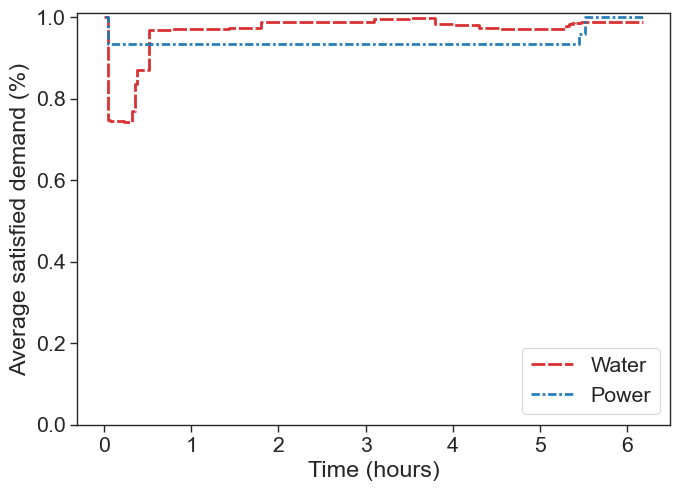

In [56]:
model_plots.plot_interdependent_effects(resilience_metrics, metric = 'pcs', title = False)

### Location of disrupted components and crews

In [57]:
model_plots.plot_disruptions_and_crews(shelby_network, basemap = True)

{'power': ['P_L62', 'P_L59', 'P_L46', 'P_L60', 'P_L69', 'P_L54'], 'water': ['W_PMA2', 'W_PMA18', 'W_PMA3', 'W_WP81', 'W_PMA6', 'W_PMA7'], 'transpo': ['T_L68', 'T_L66']}


Loading BokehJS ...

### Disruption to utility services

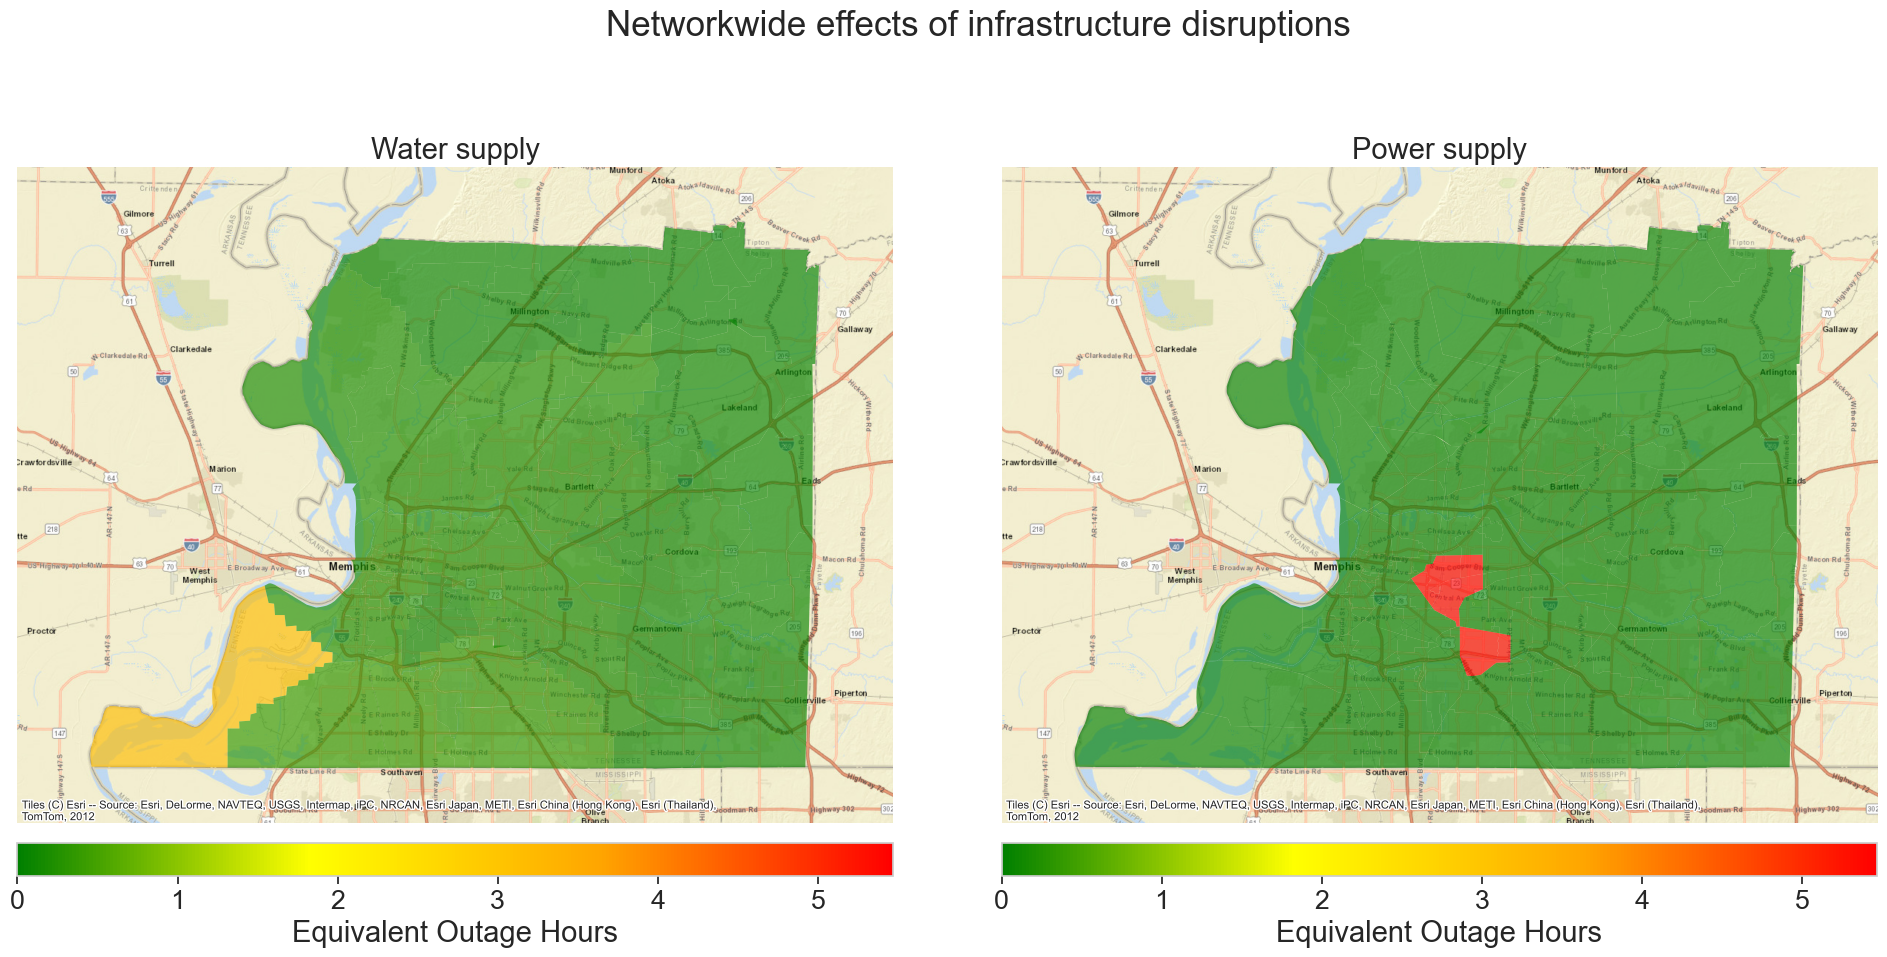

In [58]:
split_water_sa = gpd.overlay(shelby_network.wn.service_area, ShelbySE.county_gpd_truncated, how='intersection')
split_power_sa = gpd.overlay(shelby_network.pn.service_area, ShelbySE.county_gpd_truncated, how='intersection')
sa_dict = {'Water': split_water_sa, 'Power': split_power_sa}

model_plots.plot_region_impact_map(resilience_metrics, sa_dict, "capacity", extends = ShelbySE.bounds)

### Direct business disruptions

In [ ]:
ShelbySE.plot_interactive(type = "economic costs")